# Fast front-prop

Fast front-prop implementation on matrices (see original `front-prop` idea in original notebook).
This one is ~100x faster, by parallelising all neurons in the layer.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm

import importlib

from fp_utils import sphere_rnd_gen, shanon_entropy_binned, plot_matrix
from fp_datasets import get_simple_pattern, get_all_patterns

/tmp/ipykernel_2855/3595561576.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# If there's a GPU available...
if torch.cuda.is_available():
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the CPU


In [5]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})


## Simple patterns


----------------
Running frontprop on following patterns:


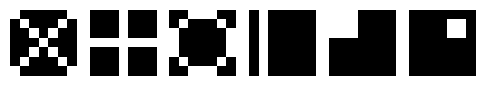

with probabilities:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



 --- Iter #0 --- 


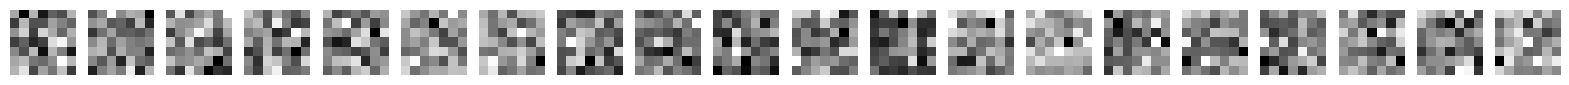


 --- Iter #2000 --- 


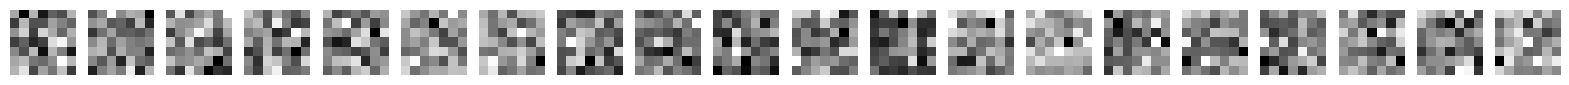


 --- Iter #4000 --- 


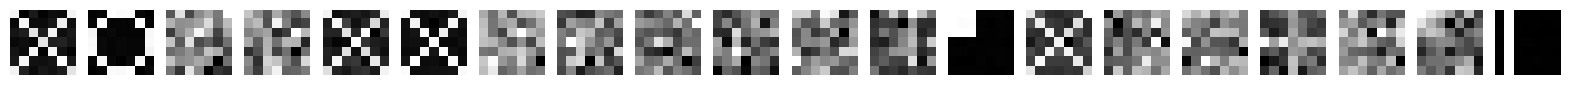


 --- Iter #6000 --- 


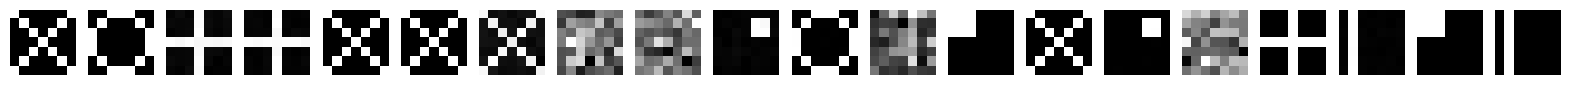


 --- Iter #8000 --- 


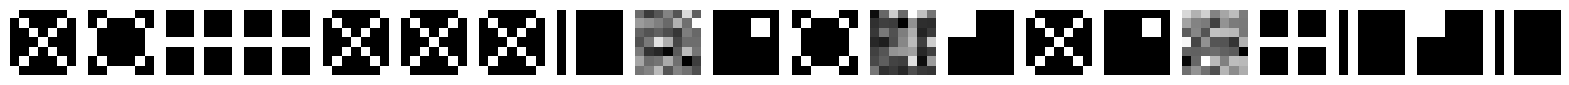


 --- Iter #10000 --- 


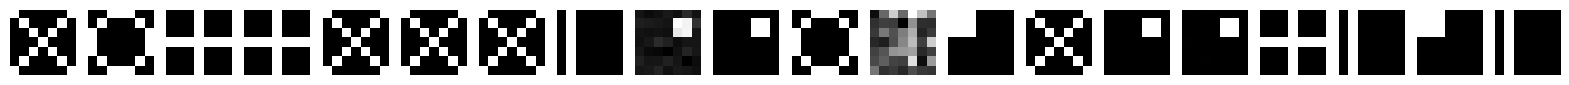


 --- Iter #12000 --- 


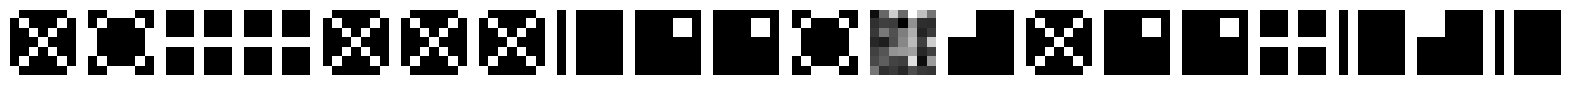


 --- Iter #14000 --- 


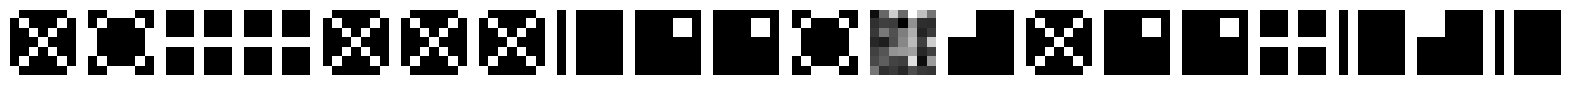


 --- Iter #16000 --- 


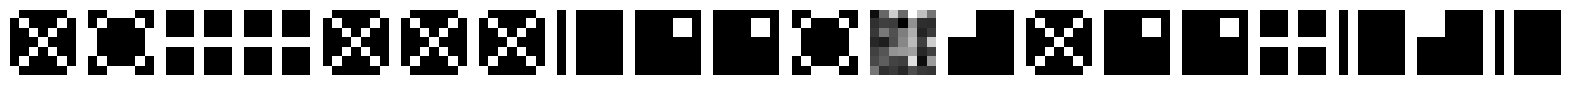


 --- Iter #18000 --- 


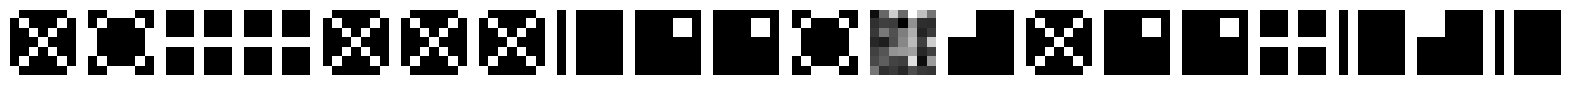

In [38]:
import torch_module as fp

DIMS = [7,7]
ITERS = 20000  # 50000
NEURONS = 20

NOISE = 0.0
PROBS = [1.0] * len(get_all_patterns())
# PROBS = [10,1,1,1,1,1]

DRAW_INTERVAL = 2000

layer = fp.FpLinear(DIMS[0] * DIMS[1], NEURONS, device=device)

print("\n----------------\nRunning frontprop on following patterns:")
plot_matrix(DIMS, *get_all_patterns())
print(f"with probabilities:\n{PROBS}\n\n")

for i in range(ITERS):

    input = get_simple_pattern(PROBS, noise=NOISE) \
        .to(device).flatten().unsqueeze(0)

    out = layer.forward(input)

    if i % DRAW_INTERVAL == 0:
        print(f"\n --- Iter #{i} --- ")
        plot_matrix(DIMS, *([layer.weight[i] for i in range(NEURONS)]))
        # print("Layer outputs:")
        # print(out)
        # print("for input")
        # plot_matrix(DIMS, input)


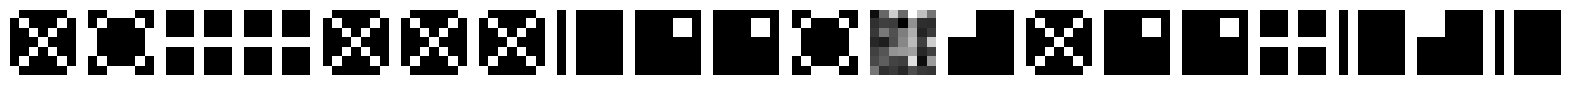

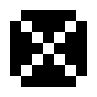

Outputs: tensor([[0.4472, 0.0000, 0.0000, 0.0000, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]])


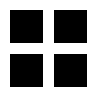

Outputs: tensor([[0.0000, 0.0000, 0.5774, 0.5774, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000,
         0.0000, 0.0000]])


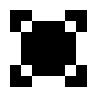

Outputs: tensor([[0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]])


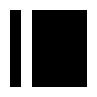

Outputs: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5774,
         0.0000, 0.5774]])


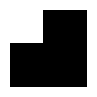

Outputs: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.7071, 0.0000]])


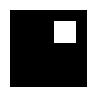

Outputs: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
         0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
         0.0000, 0.0000]])


In [39]:
plot_matrix(DIMS, *([layer.weight[i] for i in range(NEURONS)]))

activations = []
for p in get_all_patterns(len(PROBS)):
    input = p.to(device).flatten().unsqueeze(0)
    out = layer.forward(input)
    activations.append(out)
    plot_matrix(DIMS, input)
    print(f"Outputs: {out}")

activations = torch.cat(activations, dim=0)

In [40]:

# count number of activations per class (pattern)
activation_counts = torch.sum(activations > torch.mean(activations, dim=1).unsqueeze(1), dim=1).float()
# for i in range(len(activations)):
#     print(f"Pattern {i}: {torch.sum(activations[i, :] > torch.mean(activations[i, :])).item()} activations")
activation_counts /= torch.sum(activation_counts)

for i in range(len(activation_counts)):
    print(f"Pattern #{i}: {round(100.0 * activation_counts[i].item(), 2)}% activations")


Pattern #0: 26.32% activations
Pattern #1: 15.79% activations
Pattern #2: 10.53% activations
Pattern #3: 15.79% activations
Pattern #4: 10.53% activations
Pattern #5: 21.05% activations


### Conclusion
Neither noise or uneven probabilities prevent the network from learning all patterns. 

Even with pattern likelihood imbalance of 10:1, the network still learns to activate all patterns,
Amount of activations per pattern varies between 5%-25%, but, notably, is not related to pattern probability 
(i.e. more likely patterns do not get more activations).

Noise does not affect convergence, but larger amount of noise do slow down learning (as expected).

TODO: plot those two effects (activation imbalance vs pattern probs imbalance; noise vs learning speed)
